In [36]:
import json
import pandas as pd
import os
import numpy as np
import re
import tqdm
# from movie_screenplay_parser.screenplayparser import ScreenplayParser
import spacy
import torch
import time
import matplotlib.pyplot as plt

In [4]:
data_dir = os.path.join(os.getenv("DATA_DIR"), "narrative_understanding")
movie_script_index_file = os.path.join(data_dir, "movie_scripts/movie_scripts/index.csv")
imdb_id_to_imdb_data_file = os.path.join(data_dir, "movie_scripts/movie_scripts/imdb_id_to_movie.json")
chatter_dir = os.path.join(data_dir, "chatter")
chatter_scripts_dir = os.path.join(chatter_dir, "scripts")

In [4]:
index_df = pd.read_csv(movie_script_index_file, index_col=None)

In [5]:
index_df.head()

,url,file,date,imdb_id,moviedb_id,script_on_screen_synopsis
0,https://thescriptsavant.com/movies/Aaranya_Kaa...,0,Feb 15 2023,tt1496729,119123.0,A drama that unfolds between two rival mafia g...
1,https://thescriptsavant.com/movies/Abduction.pdf,1,Feb 15 2023,tt1600195,59965.0,A young man sets out to uncover the truth abou...
2,http://www.dailyscript.com/scripts/Above_the_L...,2,Feb 15 2023,tt0094602,9395.0,"Nico Toscani is an Italian immigrant, American..."
3,http://www.imsdb.com/scripts/Above-the-Law.html,3,Feb 15 2023,tt0094602,9395.0,"Nico Toscani is an Italian immigrant, American..."
4,http://www.dailyscript.com/scripts/Absolute_Po...,4,Feb 15 2023,tt0118548,66.0,A master thief coincidentally is robbing a hou...


In [6]:
index_df["imdb_id"].dropna().unique().size

2662

In [13]:
with open(imdb_id_to_imdb_data_file) as fr:
    imdb_id_to_imdb_data = json.load(fr)

In [18]:
for imdb_id in tqdm.tqdm(index_df["imdb_id"].dropna().unique()):
    index_filenames = index_df.loc[index_df["imdb_id"] == imdb_id, "file"].values
    sizes = []
    filenames = []
    for filename in index_filenames:
        script_file = os.path.join(data_dir, "movie_scripts/movie_scripts", str(filename) + ".txt")
        if os.path.exists(script_file):
            filenames.append(filename)
            with open(script_file) as fr:
                content = fr.read()
            sizes.append(len(content))
    if sizes:
        i = np.argmax(sizes)
        with open(os.path.join(data_dir, "movie_scripts/movie_scripts", str(filenames[i]) + ".txt")) as fr:
                content = fr.read()
        content = re.sub("", "", content)
        content = re.sub("\n{2,}", "\n\n", content)
        content = content.strip()
        movie_dir = os.path.join(data_dir, "chatter", imdb_id[2:])
        os.makedirs(movie_dir, exist_ok=True)
        with open(os.path.join(movie_dir, "script.txt"), "w") as fw:
            fw.write(content)
        if imdb_id[2:] in imdb_id_to_imdb_data:
            imdb_data = imdb_id_to_imdb_data[imdb_id[2:]]
            with open(os.path.join(movie_dir, "imdb.json"), "w") as fw:
                json.dump(imdb_data, fw, indent=2)

100%|██████████| 2662/2662 [01:04<00:00, 41.18it/s]


In [22]:
parser = ScreenplayParser(use_rules=False, device_id=2)

In [28]:
rule_parser = ScreenplayParser(use_rules=True, device_id=2)

In [29]:
for imdb_id in tqdm.tqdm(os.listdir(chatter_dir)):
    if re.match("\d{7,}", imdb_id):
        script_file = os.path.join(chatter_dir, imdb_id, "script.txt")
        if os.path.exists(script_file):
            with open(script_file, "r", encoding="utf-8") as fr:
                script_lines = fr.read().split("\n")
            script_tags = rule_parser.parse(script_lines)
            assert len(script_tags) == len(script_lines)
            with open(os.path.join(chatter_dir, imdb_id, "parse.txt"), "w") as fw:
                fw.write("\n".join(script_tags))

100%|██████████| 2661/2661 [04:26<00:00,  9.97it/s]


In [5]:
nlp = spacy.load("en_core_web_sm", disable="parser")
# spacy.require_gpu(gpu_id=3)

In [47]:
scene_description_lengths = []

imdb_ids = os.listdir(chatter_scripts_dir)
for imdb_id in tqdm.tqdm(imdb_ids):
    script_file = os.path.join(chatter_scripts_dir, imdb_id, "script.txt")
    parse_file = os.path.join(chatter_scripts_dir, imdb_id, "parse.txt")
    if os.path.exists(parse_file) and os.path.exists(script_file):
        with open(script_file, encoding="utf-8") as fr:
            script_lines = fr.read().strip().split("\n")
        with open(parse_file) as fr:
            parse_tags = fr.read().strip().replace("\n", "")
        for match in re.finditer("N+", parse_tags):
            i, j = match.span()
            scene_description = " ".join(script_lines[i: j])
            scene_description_lengths.append(len(scene_description.split()))

print(len(scene_description_lengths))

100%|██████████| 2660/2660 [00:12<00:00, 205.18it/s]

2402756


In [48]:
x = scene_description_lengths
print(f"mean={np.mean(x):.1f}, std={np.std(x):.3f}, median={np.median(x)}, 90%tile={np.quantile(x, 0.9):.1f}, "
      f"95%tile={np.quantile(x, 0.95):.1f}, 99%tile={np.quantile(x, 0.99):.1f}, 99.9%tile={np.quantile(x, 0.999)}")

mean=11.0, std=23.274, median=4.0, 90%tile=29.0, 95%tile=40.0, 99%tile=77.0, 99.9%tile=168.0


In [52]:
x = np.array(scene_description_lengths)
((20 <= x) & (x <= 150)).sum()

428713

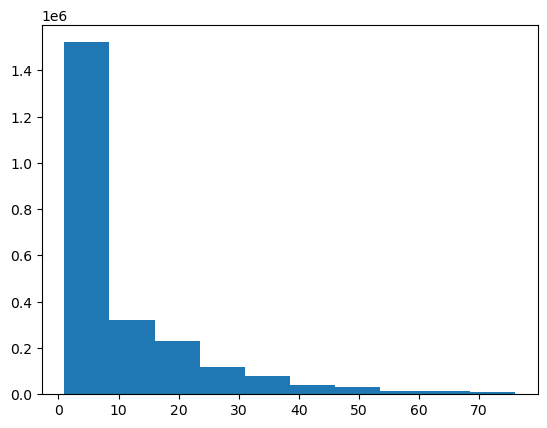

In [50]:
x = np.array(scene_description_lengths)
x = x[x < np.quantile(x, 0.99)]
plt.hist(x)
plt.show()

In [62]:
topk_characters = 10 # number of top characters to consider from the imdb cast list
n_movies = 100 # number of movies
min_words_in_character_desc = 0 # minimum number of words in character description
max_words_in_character_desc = np.inf # maximum number of words in character description
n_character_descriptions_per_character = 3 # number of descriptions per character

character_description_tups = []

imdb_ids = os.listdir(os.path.join(chatter_dir, "scripts"))
np.random.shuffle(imdb_ids)
imdb_ids = imdb_ids[:n_movies]

for imdb_id in tqdm.notebook.tqdm(imdb_ids, unit="movie"):
    if re.match("\d{7,}", imdb_id):
        script_file = os.path.join(chatter_scripts_dir, imdb_id, "script.txt")
        parse_file = os.path.join(chatter_scripts_dir, imdb_id, "parse.txt")
        imdb_file = os.path.join(chatter_scripts_dir, imdb_id, "imdb.json")

        if os.path.exists(script_file) and os.path.exists(parse_file) and os.path.exists(imdb_file):
            with open(script_file, encoding="utf-8") as fr:
                script_lines = fr.read().split("\n")
            with open(parse_file) as fr:
                script_tags = fr.read().split("\n")
            with open(imdb_file) as fr:
                script_imdb = json.load(fr)

            assert len(script_lines) == len(script_tags)

            i = 0
            scene_descriptions = []
            while i < len(script_lines):
                if script_tags[i] == "N":
                    j = i + 1
                    while j < len(script_lines) and script_tags[j] == script_tags[i]:
                        j = j + 1
                    desc = " ".join(script_lines[i: j])
                    desc = re.sub("\s+", " ", desc).strip()
                    n_words = len(desc.split())
                    if min_words_in_character_desc < n_words <= max_words_in_character_desc:
                        scene_descriptions.append(desc)
                    i = j
                else:
                    i = i + 1

            if "cast" in script_imdb:
                for person in script_imdb["cast"][:topk_characters]:
                    if isinstance(person.get("character", None), str):
                        character = person["character"]
                        character_pattern = re.compile(f"(^|\s){re.escape(character.lower())}(\s|$)")
                        character_descriptions = []
                        n = 0
                        for scene_description in scene_descriptions:
                            if re.search(character_pattern, scene_description.lower()) is not None:
                                character_descriptions.append(scene_description)
                                n += 1
                                if n >= n_character_descriptions_per_character:
                                    break
                        if character_descriptions:
                            character_description = "\n".join(character_descriptions)
                            character_description_tups.append((imdb_id, character, character_description))

print(f"{len(character_description_tups)} character descriptions")

  0%|          | 0/100 [00:00<?, ?movie/s]

498 character descriptions


In [63]:
for imdb_id, character, character_description in character_description_tups:
    print(imdb_id)
    print(character)
    print(character_description)
    print("\n")

0338751
Howard Hughes
Hello, Mr. Mayer, I don't know if you remember me, my name's Howard Hughes and I wanted to talk to you-MAYER The airplane picture.
You're not going to believe this. Just came over the wires ... Howard Hughes just bought control of TWA. A beat as Trippe looks at him. TRIPPE


0338751
Ava Gardner
AVA GARDNER


0338751
Juan Trippe
Juan Trippe is approaching the table. Trippe wears nice suit. Except for a smattering of military uniforms, Trippe and Howard are the only men in the entire club not wearing tuxedos. They are worthy adversaries. Trippe arrives at the table.
Noah and Juan Trippe head down the corridor to the elevator. A look approaching sympathy on Trippe's face.
Is it not true, Senator Brewster, that Juan Trippe donated 20,000 dollars to your last campaign and--? BREWSTER


0338751
Professor Fitz
Howard is slowly moving arqund an early prototype of wh?lt will become his astounding H-1 Racer plane. He feels along the aerodynamic sides and engine cowling. His

In [29]:
text = """A young family together in bed. It is a bright summer morning. Father, mother, and a three year old girl are still asleep. They are naked. A light breeze drifts into the room. The scene is serene and softly suspended."""
character = "Mitchell"
pattern = re.compile(f"(^|\s){re.escape(character.lower())}(\s|$)")
re.search(pattern, text.lower())

In [30]:
pattern

re.compile(r'(^|\s)mitchell(\s|$)', re.UNICODE)